In [1]:
import sys
# sys.path.append('/Users/harsh/Work/habitat-sim/')
# sys.path.append('/Users/harsh/Work/habitat-api/')

In [ ]:
cd '/srv/share3/hagrawal9/project/sokoban/habitat-api/'

In [ ]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import os
import time
from collections import deque
from typing import Dict, List, Optional

import habitat
import numpy as np
import torch
import tqdm

from torch.optim.lr_scheduler import LambdaLR
from habitat import Config, logger
from habitat import make_dataset
from habitat.utils.visualizations.utils import observations_to_image
from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class, SokobanRLEnv
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import (
    batch_obs,
    generate_video,
    linear_decay,
)
from habitat_baselines.config.default import get_config
from habitat_baselines.rl.ppo import PPO, PointNavBaselinePolicy
from habitat.utils.visualizations.utils import observations_to_image, images_to_video

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
config = get_config("habitat_baselines/config/sokoban/pickup_order_ddppo_obj_5_scene_100.yaml")

In [6]:
config.defrost()
config.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR']
config.NUM_PROCESSES = 1
config.TASK_CONFIG.ENVIRONMENT.MAX_EPISODE_STEPS = 1000
config.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ['MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT', 'GRAB_RELEASE']
config.TASK_CONFIG.TASK.SENSORS = ['GRIPPED_OBJECT_SENSOR']
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['object_5_scene_12_episode_1_gibson']
config.TASK_CONFIG.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE = False
config.freeze()

In [7]:
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)

2020-07-07 11:59:49,097 Initializing dataset Sokoban-v0


In [8]:
len(dataset.episodes)

12

In [9]:
env.close()

NameError: name 'env' is not defined

In [10]:
env = SokobanRLEnv(config=config, dataset=dataset)

2020-07-07 11:59:52,540 initializing sim SokobanSim-v0


seed: 100


2020-07-07 11:59:57,116 Initializing task Sokoban-v0


Possible Actions: OrderedDict([('MOVE_FORWARD', <habitat.tasks.nav.nav.MoveForwardAction object at 0x7fa683c5fa58>), ('TURN_LEFT', <habitat.tasks.nav.nav.TurnLeftAction object at 0x7fa683c5fa90>), ('TURN_RIGHT', <habitat.tasks.nav.nav.TurnRightAction object at 0x7fa683c5fac8>), ('GRAB_RELEASE', <habitat.tasks.sokoban.sokoban_task.GrabOrReleaseAction object at 0x7fa683c5fb00>)])


In [19]:
obs = env.reset()

In [20]:
sim = env.habitat_env.sim._sim

In [21]:
obs = sim.get_sensor_observations()

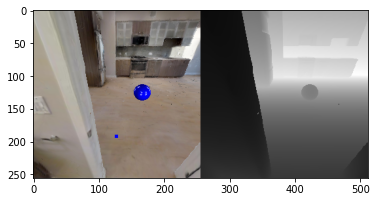

In [22]:
color_obs = obs["rgb"][:, :, :3]
color_obs[190:195, 125:130, :] = [0, 0, 255] 
depth_obs = obs["depth"]
depth_obs = ((depth_obs - np.min(depth_obs))/ np.max(depth_obs) * 255.0).astype(np.int)
depth_obs = np.transpose(np.stack([depth_obs]*3), (1,2,0))
plt.imshow(np.concatenate([color_obs, depth_obs], axis=1))